# Notebook 02-voronoi_in_city_test

This notebook takes the work developed on Notebook 00-voronoi_in_ageb_test and applies it to a city (Aguascalientes).

Helped function voronoi_points_within_polygon to work properly.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Load city data

### Load mun_gdf (Area of interest)

In [2]:
# OUTSIDE FUNCTION:
city = 'Aguascalientes'

# --------------- CREATE AREA OF INTEREST (aoi)
# Downloads mun_gdf for city and create aoi
query = f"SELECT * FROM metropolis.metro_gdf_2020 WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mun_gdf = mun_gdf.set_crs("EPSG:4326")

### Load pop data within area of interest

In [3]:
# --------------- DOWNLOAD POP DATA
aoi = mun_gdf.dissolve()
print("Loading AGEBs for area of interest.")
pop_ageb_gdf = aup.gdf_from_polygon(aoi,'censoageb','censoageb_2020')
print("Loading blocks for area of interest.")
pop_mza_gdf = aup.gdf_from_polygon(aoi,'censo_mza','censo_mza_2020')
pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()

Loading AGEBs for area of interest.
Loading blocks for area of interest.


## Methodology

### 1. Select nodes within area of interest

Created OSMnx graph from bounding polygon.
Converted OSMnx graph to 54887 nodes and 128055 edges GeoDataFrame.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Column: ref in nodes gdf, has a list in it, the column data was converted to string.


<Axes: >

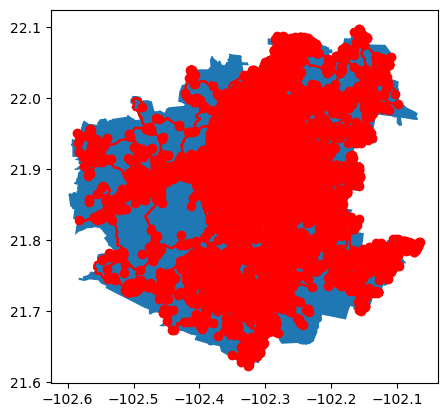

In [4]:
G, nodes, edges = aup.create_osmnx_network(aoi)

fig,ax = plt.subplots(figsize=(5,5))
nodes.plot(ax=ax,color='red',zorder=2)
edges.plot(ax=ax,zorder=1,color='red')
aoi.plot(ax=ax,zorder=0)

### 2. Create voronoi polygons using nodes

In [45]:
def voronoi_points_within_polygon (polygon, points, admissible_error = 0.01):
    # This function takes as input a polygon and points within that polygon
    # And returns the voronoi distribution of those points within that polygon

    
    #Set area of interest (polygon) and points of interest (nodes) for voronoi analysis to crs:6372
    aoi = polygon.to_crs("EPSG:6372")
    pois = points.to_crs("EPSG:6372")

    # Distance is a number used to create a buffer around the polygon and coordinates along a bounding box of that buffer.
    # Starts at 100 (works for smaller polygons) but will increase itself until the diference between the area of 
    # the voronoi polygons created and the area of the aoi is less than the admissible_error.
    distance = 100

    # Goal area (Area of aoi)
    goal_area_gdf = aoi.copy()
    goal_area_gdf['area'] = goal_area_gdf.geometry.area
    goal_area = goal_area_gdf['area'].sum()
    
    #Loop starter:
    area_diff = admissible_error + 1
    
    # Will repeat process while difference between voronoi polygons area and goal_area is more than admissible_error.
    while area_diff > admissible_error:

        print(f'Processing area of interest for distance = {distance}.')
        
        #Create a rectangular bound for the area of interest
        polygon = aoi['geometry'].unique()[0]
        bound = polygon.buffer(distance).envelope.boundary
        
        #Create points along the rectangular boundary
        boundarypoints = [bound.interpolate(distance=d) for d in range(0, np.ceil(bound.length).astype(int), distance)]
        boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])
        
        #Load the points inside the polygon
        coords = np.array(pois.get_coordinates())
        
        #Create an array of all points on the boundary and inside the polygon
        all_coords = np.concatenate((boundarycoords, coords))
        
        # Calculate voronoi to all coords and create voronois gdf (No boundary)
        vor = Voronoi(points=all_coords)
        lines = [shapely.geometry.LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
        polys = shapely.ops.polygonize(lines)
        unbounded_voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:6372")
        
        #Clip voronoi with boundary
        bounded_voronois = gpd.overlay(df1=unbounded_voronois, df2=aoi, how="intersection")
        
        # Change back crs
        voronois_gdf = bounded_voronois.to_crs("EPSG:4326")

        # Area check for while loop
        voronois_area_gdf = voronois_gdf.to_crs("EPSG:6372")
        voronois_area_gdf['area'] = voronois_area_gdf.geometry.area
        voronois_area = voronois_area_gdf['area'].sum()

        area_diff = ((goal_area - voronois_area)/(goal_area))*100
        
        if area_diff > admissible_error:
            print(f'Error = {round(area_diff,2)}%. Repeating process.')
            distance = distance * 10
        else:
            print(f'Error = {round(area_diff,2)}%. Admissible.')
            
    return voronois_gdf


Processing area of interest for distance = 100.
Error = 0.5%. Repeating process.
Processing area of interest for distance = 1000.
Error = 0.23%. Repeating process.
Processing area of interest for distance = 10000.
Error = 0.0%. Admissible.


<Axes: >

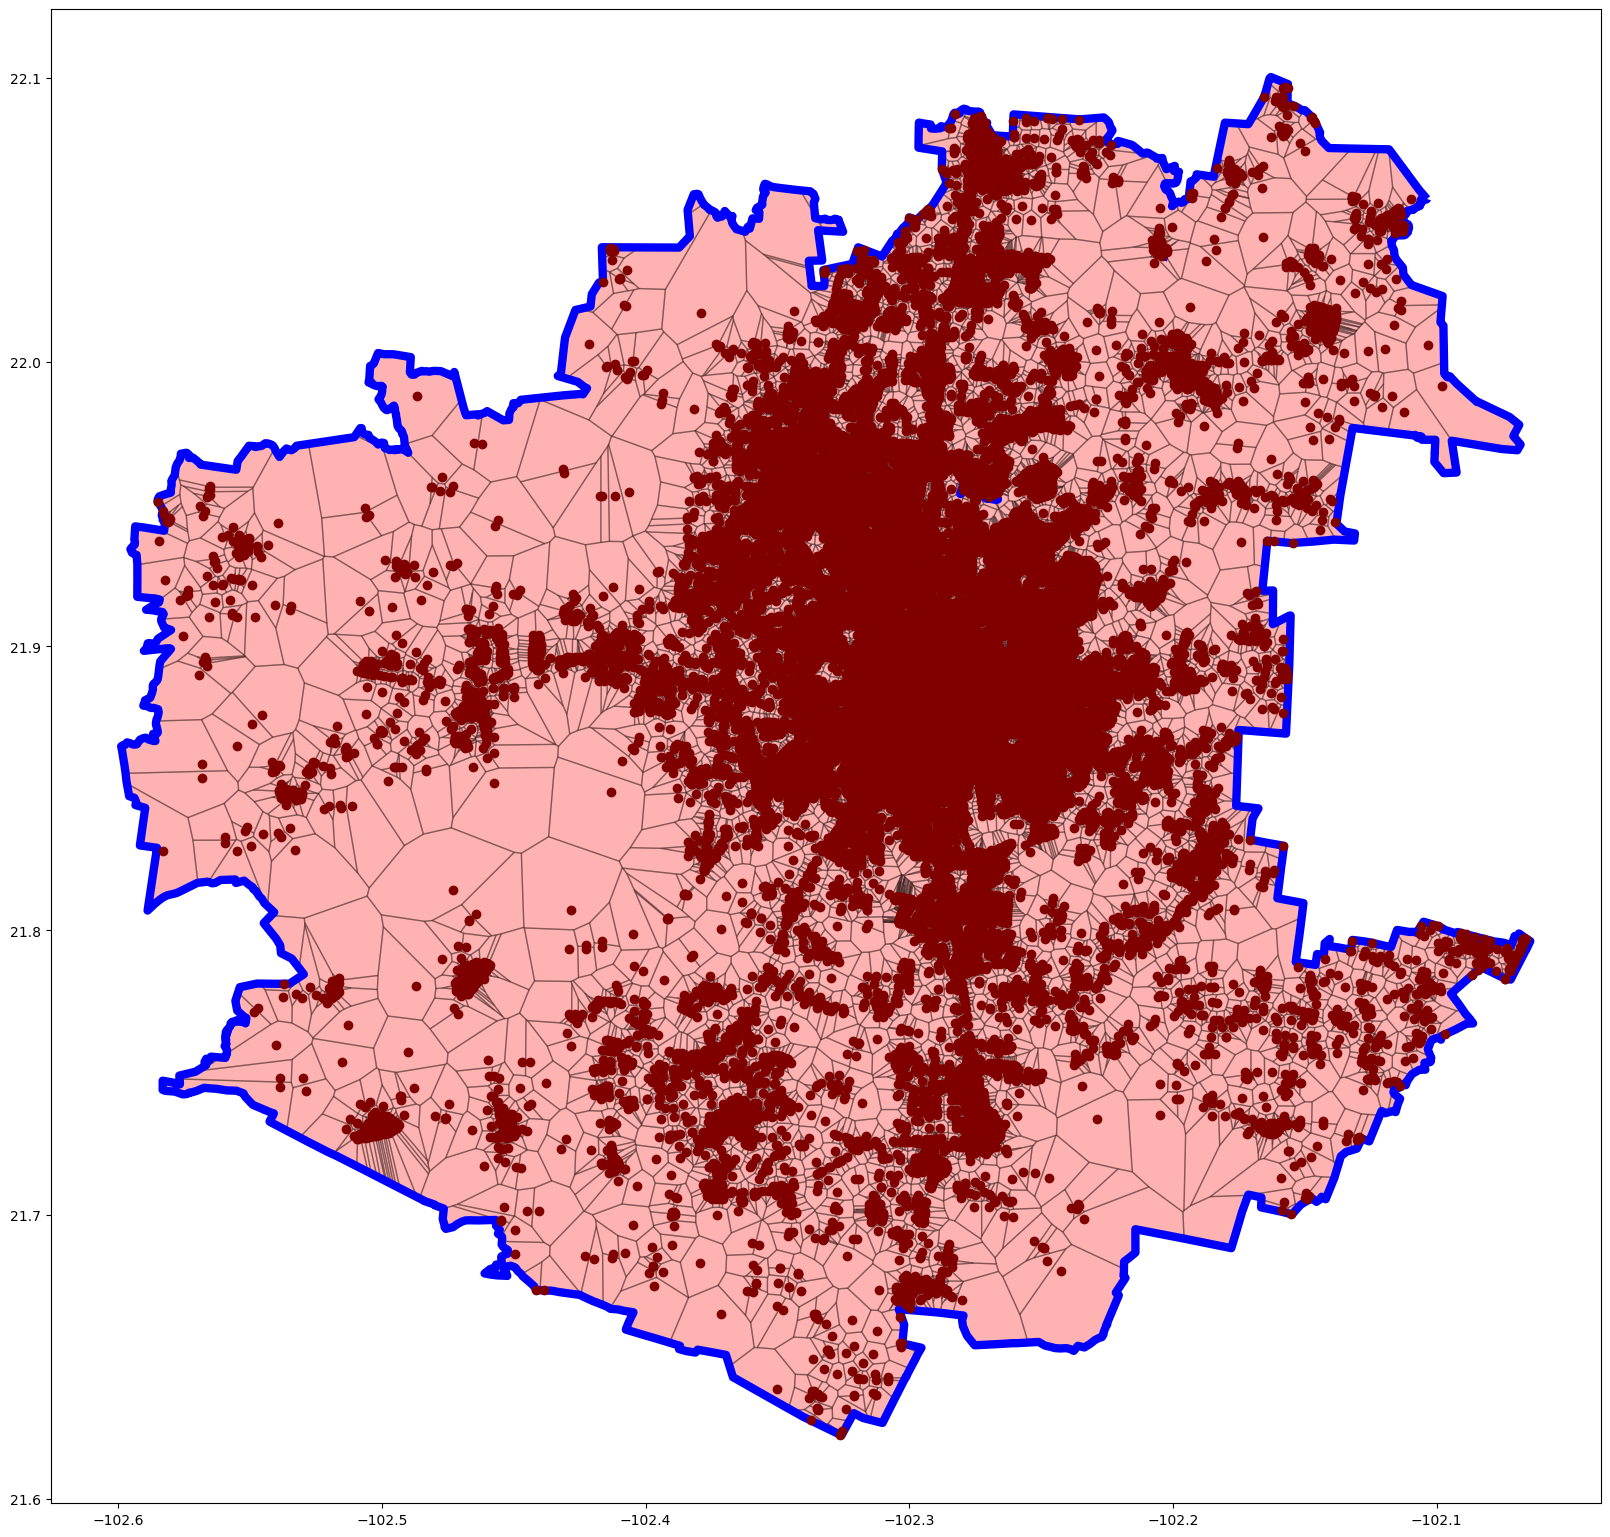

In [46]:
voronois_gdf = voronoi_points_within_polygon(aoi,nodes)

# Show
fig, ax = plt.subplots(figsize=(20, 20))
nodes.plot(ax=ax, color="maroon",zorder=2)
aoi.boundary.plot(ax=ax, edgecolor="blue", linewidth=6,zorder=1)
voronois_gdf.plot(ax=ax, color="red", alpha=0.3, edgecolor="black",zorder=0)

In [49]:
# Add nodes osmid data to voronoi polygons
nodes_voronoi_gdf = gpd.sjoin(voronois_gdf,nodes[['osmid','geometry']])
nodes_voronoi_gdf = nodes_voronoi_gdf[['osmid','geometry']]

# Show
print(nodes_voronoi_gdf.shape)
nodes_voronoi_gdf.head(1)

(54887, 2)


,osmid,geometry
0,8741846325,"POLYGON ((-102.11228 22.05574, -102.11251 22.0..."


### 3. Spatial intersection of voronoi polygons with blocks. Calculate pct of area that corresponds to each osmid within block.

In [53]:
# Calculate block area
mza_gdf = pop_mza_gdf.to_crs("EPSG:6372")
mza_gdf['area_mza'] = mza_gdf.geometry.area
mza_gdf = mza_gdf.to_crs("EPSG:4326")

# Overlay blocks with voronoi
mza_voronoi = gpd.overlay(df1=mza_gdf, df2=nodes_voronoi_gdf, how="intersection")
del mza_gdf

# Calculate area distribution of block in voronoi zones
mza_voronoi = mza_voronoi.to_crs("EPSG:6372")
mza_voronoi['area_voronoi'] = mza_voronoi.geometry.area
mza_voronoi = mza_voronoi.to_crs("EPSG:4326")
mza_voronoi['area_pct'] = mza_voronoi['area_voronoi']/mza_voronoi['area_mza']

# Drop used columns
mza_voronoi.drop(columns=['area_mza','area_voronoi'],inplace=True)

# Show
print(mza_voronoi.shape)
mza_voronoi.head(1)

(84264, 241)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,ENTIDAD,NOM_ENT,...,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,osmid,geometry,area_pct
0,0100100010229001,01,001,0001,0229,001,Urbana,Típica,1,Aguascalientes,...,17,16,6,0,0,None,0,9708499614,"POLYGON ((-102.29553 21.92908, -102.29531 21.9...",0.089326


### 4. Sum of pob data that corresponds to each node

In [59]:
len(mza_voronoi.osmid.unique())

35950

In [61]:
columns_of_interest = ['POBTOT','POBFEM','POBMAS',
                    'P_0A2','P_0A2_F','P_0A2_M',
                    'P_3A5','P_3A5_F','P_3A5_M',
                    'P_6A11','P_6A11_F','P_6A11_M',
                    'P_12A14','P_12A14_F','P_12A14_M',
                    'P_15A17','P_15A17_F','P_15A17_M',
                    'P_18A24','P_18A24_F','P_18A24_M',
                    'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                    'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                    'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                    'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                    'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
                    'REL_H_M','POB0_14','POB15_64','POB65_MAS']

nodes_gdf = nodes.copy()

for col in columns_of_interest:
    # Turn column to numeric 
    mza_voronoi[col] = pd.to_numeric(mza_voronoi[col])

    # Calculate population proportional to voronoi area of block
    mza_voronoi[f'voronoi_{col}'] = mza_voronoi[col] * mza_voronoi['area_pct']
    
    # Group data by osmid
    col_data = mza_voronoi[['osmid',f'voronoi_{col}']]
    osmid_grouped_data = col_data.groupby('osmid').agg({f'voronoi_{col}':np.sum})
    
    # Merge data to nodes_gdf
    osmid_grouped_data.reset_index(inplace=True)
    nodes_gdf = pd.merge(nodes_gdf,osmid_grouped_data,on='osmid')
    nodes_gdf.rename(columns={f'voronoi_{col}':col},inplace=True)

print(nodes_gdf.shape)
nodes_gdf.head(1)

(35950, 45)


,osmid,x,y,street_count,geometry,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,...,P_15YMAS,P_15YMAS_F,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,REL_H_M,POB0_14,POB15_64,POB65_MAS
0,272921360,-102.295073,21.872876,3,POINT (-102.29507 21.87288),0.828358,0.373917,0.405077,0.0,0.0,...,0.747835,0.358337,0.389497,0.701095,0.358337,0.342758,1.687769,0.0,0.638775,0.109059


## Visual test

In [89]:
nodes_pop_gdf = aup.gdf_from_polygon(aoi,'censo','nodes_pop_2020')

In [91]:
# Show
print(nodes_pop_gdf.shape)
nodes_pop_gdf.head(1)

(34812, 240)


,x,y,street_count,geometry,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,entidad,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
0,-102.297863,21.873383,1,POINT (-102.29786 21.87338),0100100010854,01,001,0001,0854,1,...,7.043478,5.217391,3.695652,2.152174,1.195652,0.108696,0.326087,2.173913,0.0,0100100010854


<Axes: >

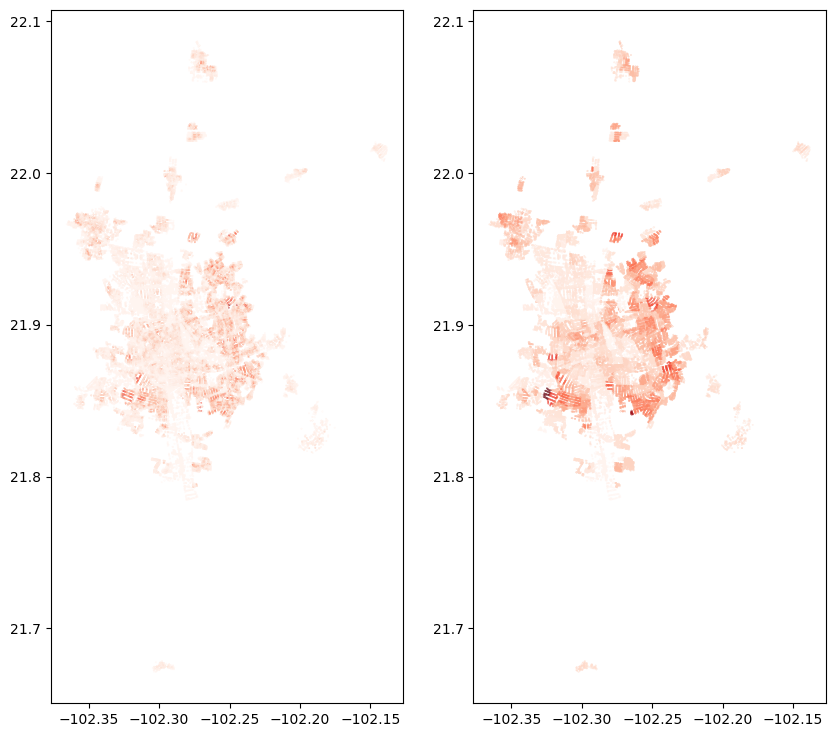

In [92]:
fig, ax = plt.subplots(1,2,figsize=(10, 10))
nodes_gdf.plot('POBTOT',ax=ax[0],markersize=.05,cmap='Reds')
nodes_pop_gdf.plot('pobtot',ax=ax[1],markersize=.05,cmap='Reds')

In [95]:
pop_mza_gdf.POBTOT.sum()

1041064

In [102]:
pop_mza_gdf.loc[pop_mza_gdf.POBTOT.isna()]

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC


In [93]:
nodes_gdf.POBTOT.sum()

1041063.9767578315

In [111]:
test_df = pd.DataFrame()


test_cols = columns_of_interest.copy()
test_cols.remove('REL_H_M')

i = 0
for col in test_cols:
    # Turn column to numeric 
    pop_mza_gdf[col] = pd.to_numeric(pop_mza_gdf[col])
    pop_ageb_gdf[col.lower()] = pd.to_numeric(pop_ageb_gdf[col.lower()])

    
    # Get values of col
    blocks_value = pop_mza_gdf[col].sum()
    nodes_value = nodes_gdf[col].sum()
    ageb_value = pop_ageb_gdf[col.lower()].sum()
    db_nodes_value = nodes_pop_gdf[col.lower()].sum()

    # Assign values to corresponding row
    test_df.loc[i,'atr'] = col
    test_df.loc[i,'blocks'] = blocks_value
    test_df.loc[i,'nodes'] = nodes_value
    test_df.loc[i,'ageb'] = ageb_value
    test_df.loc[i,'db_nodes'] = db_nodes_value

    i = i+1

# Find differences in data and methodologies
test_df['diff'] = test_df['nodes'] - test_df['blocks']
test_df['blocks_diff'] = test_df['blocks'] - test_df['ageb']
test_df['diff_db'] = test_df['db_nodes'] - test_df['ageb']

# Find sum of differences and assign to final row 'TOTAL'
diff_sum = test_df['diff'].sum()
blocks_diff_sum = test_df['blocks_diff'].sum()
diff_db_sum = test_df['diff_db'].sum()

test_df.loc[i,'atr'] = 'TOTAL'
test_df.loc[i,'diff'] = diff_sum
test_df.loc[i,'blocks_diff'] = blocks_diff_sum
test_df.loc[i,'diff_db'] = diff_db_sum

# Format - reorder columns
test_df = test_df[['atr','blocks','nodes','diff','ageb','blocks_diff','db_nodes','diff_db']]

# Show
test_df

,atr,blocks,nodes,diff,ageb,blocks_diff,db_nodes,diff_db
0,POBTOT,1041064.0,1.041064e+06,-0.023242,1042295.0,-1231.0,1042295.0,0.000000e+00
1,POBFEM,533123.0,5.331230e+05,-0.011897,535124.0,-2001.0,535124.0,0.000000e+00
2,POBMAS,505019.0,5.050190e+05,-0.010652,507171.0,-2152.0,507171.0,0.000000e+00
3,P_0A2,44813.0,4.481300e+04,-0.001201,49577.0,-4764.0,49577.0,0.000000e+00
4,P_0A2_F,18227.0,1.822700e+04,-0.000528,24481.0,-6254.0,24481.0,-3.637979e-12
5,P_0A2_M,18903.0,1.890300e+04,-0.000577,25072.0,-6169.0,25072.0,-3.637979e-12
6,P_3A5,50527.0,5.052700e+04,-0.001744,55113.0,-4586.0,55113.0,0.000000e+00
7,P_3A5_F,20781.0,2.078100e+04,-0.000406,27090.0,-6309.0,27090.0,0.000000e+00
8,P_3A5_M,21878.0,2.187800e+04,-0.001029,28005.0,-6127.0,28005.0,0.000000e+00
9,P_6A11,107407.0,1.074070e+05,-0.002909,110094.0,-2687.0,110094.0,0.000000e+00
